# Multi Agent Collaboration

In [9]:
import os
import getpass

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

#for tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-Agent Collaboration"

### Create a Helper function

In [27]:
import json

from langchain_core.messages import(
    BaseMessage,
    ToolMessage,
    HumanMessage,
)

from langgraph.graph import END, StateGraph
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

#this is the blueprint for creating Agnets
def create_agent(llm, tools, system_message: str):

    prompt = ChatPromptTemplate.from_messages(
        [
        
                "system",
                "you are a helpful AI assistant, collaborating with other AI assistants",
                "Use the provided tools to progress towards answerng the question",
                "if you are unable to fully answer the question, thats okay, another assistant with a different tool will help where you left off"
                "Execute what you can to make progress"
                "If you or any other of the assistants have the final answer or deliverable,"
                "prefix your response with FINAL ANSWER so the team knows to stop."
                "you have access to the following tools: {tool_names}.\n{system_message}",
            
            MessagesPlaceholder(variable_name = "messages"),
        ]
    )
    prompt = prompt.partial(system_message = system_message)
    prompt = prompt.partial(tool_names =", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

### Create a Tool

In [19]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results = 3)

repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """use this to execute python code. if you want to see the ouput of a value,
    you should print it out wit 'print(...)'.This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed: \n'''python\n{code}\n'''\nStdout: {result}"
    return(
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

### Define State

In [20]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

#we are tracking the message and the most resent sender
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add] 
    sender: str

### Define Agent Nodes

In [30]:
import functools
from langchain_core.messages import AIMessage

#helper function to create a node for an Agent
def agent_node(state, agent, name):
    result = agent.invoke(state)

    if isinstance(result, ToolMessage):
        pass
    else:
        results = AIMessage(**result.dict(exclude = {"type", "name"}), name = name)
    return {
        "messages": [result],
        "sender":name
    }

llm = ChatOpenAI(model = "gpt-3.5-turbo")

#research Agent
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message = "You should provide accurate data for the chart_generator to use.",
) 
research_node = functools.partial(agent_node, agent = research_agent, name = "Researcher")

#chart generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message = "Any charts you display will be visible by the user.",
)

chart_node = functools.partial(agent_node, agent =chart_agent, name = "chart_generator")

### Define Tool Node

In [31]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

### Define Edge Logic

In [32]:
from typing import Literal

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    #this is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    return "continue"

### Define the Graph

In [33]:
#putting everything in graph
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool":"call_tool", "__end__":END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__":END},
)
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

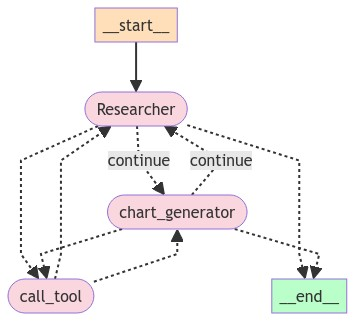

In [37]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

### Invoke

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DfsNuCuU82ljlcux6snJ1yvj', 'function': {'arguments': '{"query":"GDP of Nigeria over the past 10 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 251, 'total_tokens': 278}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e4091287-9852-40d2-9ad1-e1ea42a95f2b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'GDP of Nigeria over the past 10 years'}, 'id': 'call_DfsNuCuU82ljlcux6snJ1yvj'}])], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"url": "https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?end=2021&locations=NG&start=1961&view=chart", "content": "GDP growth (annual %) - Nigeria. World Bank national accounts data, and OECD National Accounts data files. License :

Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EqYevUxylka8Hi7a23viEeBl', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Data for Nigeria\'s GDP over the past 10 years\\nyears = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]\\ngdp_values = [414.10, 503.00, 568.50, 481.07, 404.65, 375.77, 397.27, 474.52, 432.20, 440.84]\\n\\n# Create a line graph\\nplt.figure(figsize=(12, 6))\\nplt.plot(years, gdp_values, marker=\'o\', color=\'b\', linestyle=\'-\', linewidth=2)\\nplt.title(\'GDP of Nigeria Over the Past 10 Years\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP (in billion USD)\')\\nplt.grid(True)\\nplt.xticks(years)\\nplt.tight_layout()\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 229, 'prompt_tokens': 828, 'total_tokens': 1057}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'l

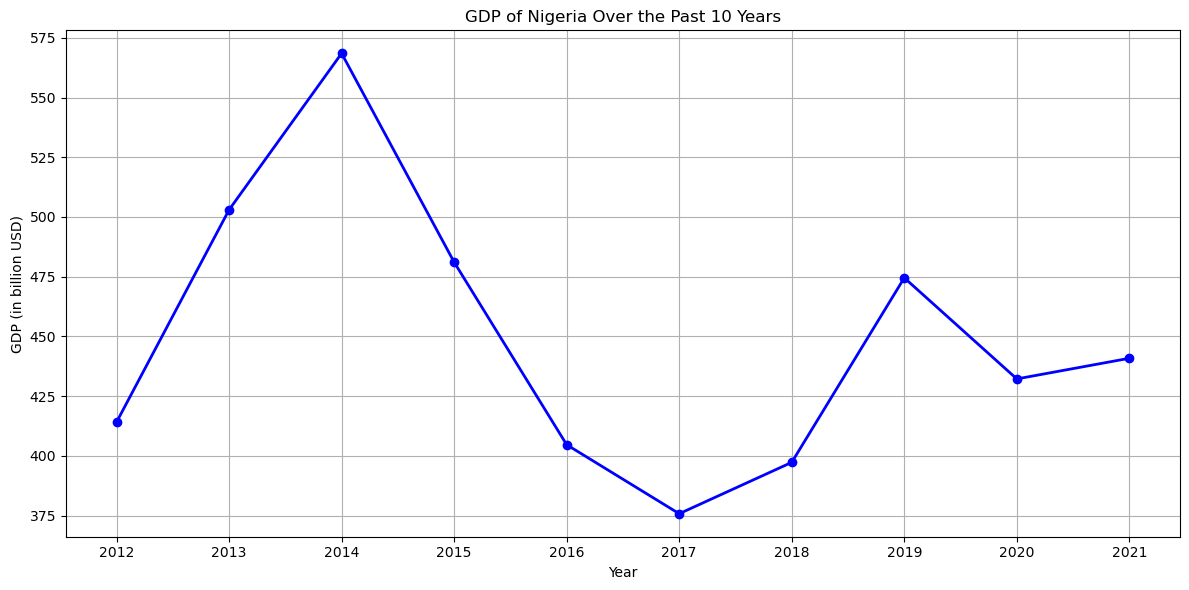

{'call_tool': {'messages': [ToolMessage(content="Successfully executed: \n'''python\nimport matplotlib.pyplot as plt\n\n# Data for Nigeria's GDP over the past 10 years\nyears = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]\ngdp_values = [414.10, 503.00, 568.50, 481.07, 404.65, 375.77, 397.27, 474.52, 432.20, 440.84]\n\n# Create a line graph\nplt.figure(figsize=(12, 6))\nplt.plot(years, gdp_values, marker='o', color='b', linestyle='-', linewidth=2)\nplt.title('GDP of Nigeria Over the Past 10 Years')\nplt.xlabel('Year')\nplt.ylabel('GDP (in billion USD)')\nplt.grid(True)\nplt.xticks(years)\nplt.tight_layout()\nplt.show()\n'''\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='call_EqYevUxylka8Hi7a23viEeBl')]}}
----
{'chart_generator': {'messages': [AIMessage(content="I have created a line graph illustrating the GDP of Nigeria over the past 10 years. The graph provides a visual representation of the changes in Nigeri

In [40]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content = "Fetch the GDP of Nigeria over the aast 10 years,"
                "then draw a line graph of it."
                "perform some data analysis of the GDP data you got,"
                "once you code and provide your analysis, finish"
            )
        ]
    },
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")